## Training and deploying a SpatialProp model

This tutorial demonstrates how to train a SpatialProp model from scratch and deploy it for scoring on a coronal mouse tissue brain section. 

We will make use of the `aging_coronal.h5ad` dataset from [Sun et al., 2025](https://www.nature.com/articles/s41586-024-08334-8). This dataset includes coronal brain sections from mice at 20 different ages tiling the entire lifespan. Spatial transcriptomics of 300 genes were profiled with MERFISH technology. To download the dataset, run the following cell:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! mkdir -p ./data
! if [ ! -f ./data/aging_coronal.h5ad ]; then \
      echo "Downloading aging_coronal.h5ad..."; \
      wget https://zenodo.org/records/13883177/files/aging_coronal.h5ad -O ./data/aging_coronal.h5ad; \
    else \
      echo "File already exists: ./data/aging_coronal.h5ad — skipping download."; \
  fi

File already exists: ./data/aging_coronal.h5ad — skipping download.


With SpatialProp installed (see Installation section of [README.md](../README.md)), run the following cell to import the API:

In [17]:
import os
import scanpy as sc 
import torch

from spatial_gnn.api.perturbation_api import (
    train_perturbation_model,
    create_perturbation_input_matrix,
    predict_perturbation_effects, 
    predict_perturbation_effects
)
from spatial_gnn.utils.plot_utils import (
    plot_loss_curves,
    plot_celltype_performance,
    plot_celltypes_in_section,
    plot_propagation_results_for_gene_set
)

### Define and train the GNN

Training the SpatialProp GNN requires defining the set of training arguments detailed in the [perturbation training API](../src/spatial_gnn/api/perturbation_api.py) docstring. Here we reuse the model configuration reported in the paper. 

Graphs are constructed using 2-hop neighbors centered around cells of all cell types, and we limit to 100 cells per cell type. We augment the training and test sets with 2-hop neighborhood graphs around each surrounding cell. Here we train the base model which does not use cell type labels as a feature.

For the purposes of the demo, we train using a single mouse's data and evaluate on a held-out mouse's data.

In [4]:
adata_path = "./data/aging_coronal.h5ad"
train_ids = ["14"]
test_ids = ["57"]
exp_name = "api_demo"

In [7]:
training_args = {
    "dataset": "aging_coronal",
    "file_path": adata_path,
    "train_ids": train_ids, 
    "test_ids": test_ids,
    "k_hop": 2,
    "augment_hop": 2,
    "center_celltypes": "all",
    "node_feature": "expression",
    "inject_feature": "none",
    "learning_rate": 0.0001,
    "loss": "weightedl1",
    "epochs": 30,
    "normalize_total": True,
    "num_cells_per_ct_id": 100,
    "predict_celltype": False,
    "pool": "center",
    "do_eval": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

The training API call will trigger construction of the graph dataset in the `./data/gnn_datasets/` directory.

In [8]:
test_loader, gene_names, (model, model_config, trained_model_path) = train_perturbation_model(
    **training_args,
)

Training new perturbation model from scratch...
Model will be saved to: ./output/None/aging_coronal_expression_2hop_2augment_expression_none/weightedl1_1en04
Training on device: cuda
Dataset already exists at:  ./data/gnn_datasets/aging_coronal_expression_100per_2hop_2C0aug_200delaunay_expressionFeat_all_NoneInject_subset_57/test
Finished processing test dataset
Dataset already exists at:  ./data/gnn_datasets/aging_coronal_expression_100per_2hop_2C0aug_200delaunay_expressionFeat_all_NoneInject_subset_14/train
Finished processing train dataset


100%|██████████| 51/51 [00:09<00:00,  5.26it/s]
/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 51/51 [00:07<00:00,  6.51it/s]

Train samples: 24879
Test samples: 24997


Expression model initialized on cuda
Starting Baseline training for 30 epochs...
 Epoch: 001, Train WL1: 9.5205, Test WL1: 9.5636, Test Spearman: 0.1243
 Epoch: 002, Train WL1: 8.6376, Test WL1: 8.7208, Test Spearman: 0.3268
 Epoch: 003, Train WL1: 8.0666, Test WL1: 8.1698, Test Spearman: 0.4637
 Epoch: 004, Train WL1: 7.7798, Test WL1: 7.8902, Test Spearman: 0.4984
 Epoch: 005, Train WL1: 7.5708, Test WL1: 7.6955, Test Spearman: 0.5143
 Epoch: 006, Train WL1: 7.4066, Test WL1: 7.5406, Test Spearman: 0.5257
 Epoch: 007, Train WL1: 7.2906, Test WL1: 7.4273, Test Spearman: 0.5335
 Epoch: 008, Train WL1: 7.1741, Test WL1: 7.3188, Test Spearman: 0.5397
 Epoch: 009, Train WL1: 7.0898, Test WL1: 7.2372, Test Spearman: 0.5459
 Epoch: 010, Train WL1: 7.0089, Test WL1: 7.1573, Test Spearman: 0.5481
 Epoch: 011, Train WL1: 6.9416, Test WL1: 7.0902, Test Spearman: 0.5518
 Epoch: 012, Train WL1: 6.8761, Test WL1: 7.0301, Test Spearman: 0.5551
 Epoch: 013, Train WL1: 6.8187, Test WL1: 6.9747, Test 

100%|██████████| 49/49 [00:04<00:00, 11.68it/s]


Computing micro and macro averages...
Finished cell type analysis.
Training completed. Model saved to: output/None/aging_coronal_expression_2hop_2augment_expression_none/weightedl1_1en04/model.pth


### Inspect GNN training performance

We can inspect the GNN training performance using `plot_utils`. We first verify convergence during training by plotting loss curves for the weighted-l1 loss used during training:

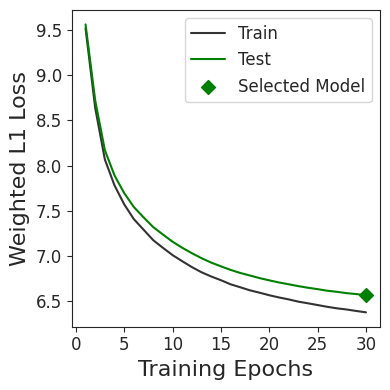

In [9]:
model_dir = os.path.dirname(trained_model_path)
plot_loss_curves(model_dir)

We can also plot performance per cell type. Here we show correlation metrics for the masked center cell expression predicted during training.

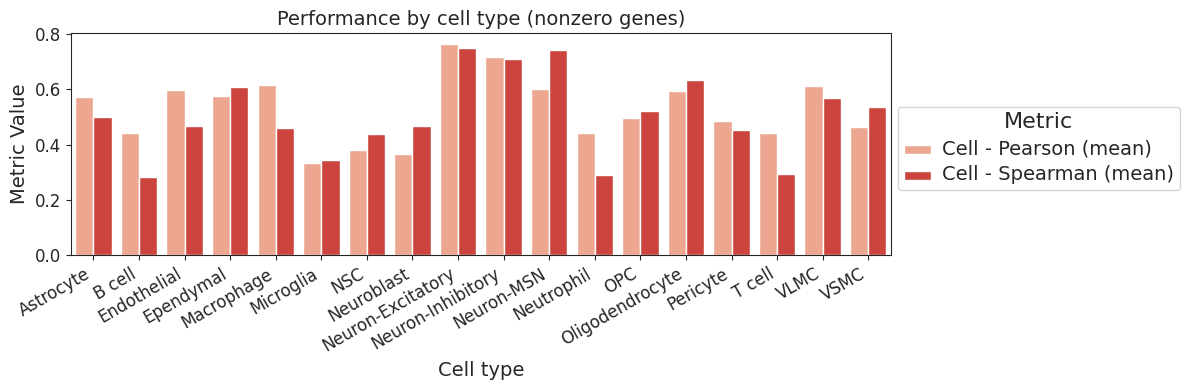

In [10]:
plot_celltype_performance(model_dir)

### Inference on the deployed SpatialProp model

Now that we have trained the SpatialProp model, we can use it to predict spatial propagations in unseen data. Here we again use held-out `mouse_id` 57. First define a set of perturbations in the form of a dictionary mapping `cell type` → `gene name` → `multiplier`. For instance, entry `'T cell': {'Igf2': 0.0},` indicates knockout of IGF2 in all T cells. 

In this example, we amplify a set of production genes by a factor of 10 in T cells and microglia:

In [11]:
production_genes = ["Ifng", "Il6", "Tnf", "Il1a", "Il1b", "Jun", "Apoe", "B2m", "C1qa", "Cd69", "Cd9", "Lyz2"]
perturbation_dict = {
    "T cell": {gene: 10.0 for gene in production_genes},
    "Microglia": {gene: 10.0 for gene in production_genes},
}
save_path = "./data/perturbed_adata/aging_coronal_perturbed.h5ad"

We call `create_perturbation_input_matrix()` to save down the perturbed input expression into the anndata object. By default, this is saved into `anndata.obsm['perturbed_input']`.

In [12]:
adata = sc.read_h5ad(adata_path)
save_path = create_perturbation_input_matrix(adata, perturbation_dict, save_path=save_path)

Applying perturbations to 1042 cells of type 'T cell'
  - Gene 'Ifng': multiplier = 10.0
  - Gene 'Il6': multiplier = 10.0
  - Gene 'Tnf': multiplier = 10.0
  - Gene 'Il1a': multiplier = 10.0
  - Gene 'Il1b': multiplier = 10.0
  - Gene 'Jun': multiplier = 10.0
  - Gene 'Apoe': multiplier = 10.0
  - Gene 'B2m': multiplier = 10.0
  - Gene 'C1qa': multiplier = 10.0
  - Gene 'Cd69': multiplier = 10.0
  - Gene 'Cd9': multiplier = 10.0
  - Gene 'Lyz2': multiplier = 10.0
Applying perturbations to 55514 cells of type 'Microglia'
  - Gene 'Ifng': multiplier = 10.0
  - Gene 'Il6': multiplier = 10.0
  - Gene 'Tnf': multiplier = 10.0
  - Gene 'Il1a': multiplier = 10.0
  - Gene 'Il1b': multiplier = 10.0
  - Gene 'Jun': multiplier = 10.0
  - Gene 'Apoe': multiplier = 10.0
  - Gene 'B2m': multiplier = 10.0
  - Gene 'C1qa': multiplier = 10.0
  - Gene 'Cd69': multiplier = 10.0
  - Gene 'Cd9': multiplier = 10.0
  - Gene 'Lyz2': multiplier = 10.0
Saved AnnData with perturbation input to: ./data/perturbed

We can now call the main function which performs the spatial propagations. Internally, this calls the SpatialProp model for each cell in the dataset and executes the SparseRenorm procedure to temper the predictions.

In [13]:
adata_result = predict_perturbation_effects(
    save_path, trained_model_path, exp_name, use_ids=test_ids
)

Loaded model configuration:
  - input_dim: 300
  - output_dim: 300
  - inject_dim: 0
  - num_layers: 2
  - method: GIN
  - pool: center
Loaded pretrained model from: output/None/aging_coronal_expression_2hop_2augment_expression_none/weightedl1_1en04/model.pth
Creating graphs from input data...
Creating new dataset at: ./data/gnn_datasets/api_demo_expression_100per_2hop_2C0aug_200delaunay_expressionFeat_all_NoneInject_subset_57/predict

Processing file 1/1: aging_coronal_perturbed.h5ad
  Normalizing data


/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


  Processing 1 samples
  Using sequential processing for 1 samples


  0%|          | 0/1 [00:00<?, ?it/s]

Sample 1: 57 (PID: 3624058)


/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/squidpy/gr/_utils.py:203: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


Selected 79824 center cells from 79824 total cells


/oak/stanford/groups/akundaje/abuen/spatial/spatial-gnn/src/spatial_gnn/datasets/spatial_dataset.py:347: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  y = torch.tensor([graph_label]).flatten(),


Created 79824 subgraphs


100%|██████████| 1/1 [56:57<00:00, 3417.57s/it]

Created 79824 augmented subgraphs


Total subgraphs created: 159648
Creating new dataset at: ./data/gnn_datasets/api_demo_expression_100per_2hop_2C0aug_200delaunay_expressionFeat_all_NoneInject_perturbed_subset_57/predict

Processing file 1/1: aging_coronal_perturbed.h5ad
  Normalizing data


/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


  Processing 1 samples
  Using sequential processing for 1 samples


  0%|          | 0/1 [00:00<?, ?it/s]

Sample 1: 57 (PID: 3624058)


/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/squidpy/gr/_utils.py:203: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


Selected 79824 center cells from 79824 total cells
Created 79824 subgraphs


100%|██████████| 1/1 [1:02:31<00:00, 3751.59s/it]

Created 79824 augmented subgraphs


Total subgraphs created: 159648


100%|██████████| 320/320 [02:36<00:00,  2.05it/s]
/users/abuen/miniconda3/envs/spatial-prop/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 320/320 [01:51<00:00,  2.87it/s]


Starting prediction for 79824 cells, 300 genes


Predicting (unperturbed & perturbed) with tempering...:   0%|          | 0/312 [00:00<?, ?it/s]/oak/stanford/groups/akundaje/abuen/spatial/spatial-gnn/src/spatial_gnn/models/gnn_model.py:1078: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_expn_batch = torch.tensor(
Predicting (unperturbed & perturbed) with tempering...: 100%|██████████| 312/312 [00:48<00:00,  6.46it/s]
/oak/stanford/groups/akundaje/abuen/spatial/spatial-gnn/src/spatial_gnn/models/gnn_model.py:1105: ImplicitModificationWarning: Setting element `.layers['predicted_unperturbed']` of view, initializing view as actual.
  adata.layers["predicted_unperturbed"] = unperturbed_prediction_matrix


Predicted on 79824 cells
Applied tempering with method 'distribution_renormalize' (batch-wise)
Perturbation prediction completed successfully!


### Visualize SpatialProp results

We can now use `plot_utils` to visualize the results. We first visualize the spatial distribution of cell types in the test mouse section using the anndata object:

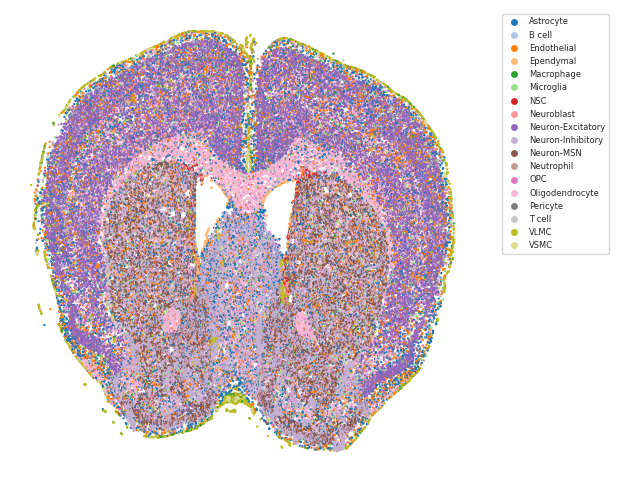

In [16]:
plot_celltypes_in_section(adata_result, ct_key="celltype", s=0.5, figsize=(6,6))

For a given response gene set, we can visualize the results of SpatialProp by plotting the sum of the response geneset expression in section. We can access the predictions of SpatialProp in the returned anndata object through `adata_result.layers['predicted_perturbed']` (raw predictions without SparseRenorm) and `adata_result.layers['predicted_tempered']` (full SpatialProp pipeline).

In [24]:
response_genes = ["Stat1", "Bst2", "Jak1", "Ifit1", "Cdkn1a", "Cdkn2a", "C4b", "H2-D1", "H2-K1"]

original_expn = adata_result.X
perturbed_expn = adata_result.layers["predicted_perturbed"]
tempered_expn = adata_result.layers["predicted_tempered"]

/oak/stanford/groups/akundaje/abuen/spatial/spatial-gnn/src/spatial_gnn/utils/plot_utils.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.90, 0.95])


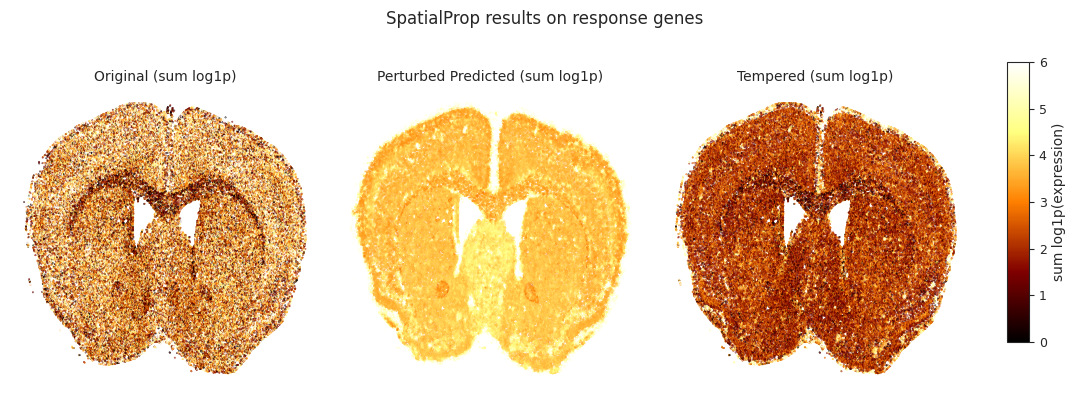

In [25]:
plot_propagation_results_for_gene_set(
    adata_result,
    response_genes,
    orig_layer=original_expn,
    pert_layer=perturbed_expn,
    temp_layer=tempered_expn,
    fig_title="SpatialProp results on response genes",
    save_path="./data/aging_coronal_perturbed_mouse_57_result.png",
    point_size=0.1,
)